# Projet 11 - Big Data Cloud : Classification de Fruits

**Auteur** : David Scanu  
**Date** : Octobre 2025  
**Objectif** : Développement local du pipeline PySpark avec broadcast TensorFlow et PCA

---

## 📋 Sommaire

1. [Setup et Configuration](#1-setup-et-configuration)
2. [Initialisation PySpark](#2-initialisation-pyspark)
3. [Chargement et Exploration des Données](#3-chargement-et-exploration-des-données)
4. [Extraction de Features avec TensorFlow](#4-extraction-de-features-avec-tensorflow)
5. [Broadcast des Poids du Modèle](#5-broadcast-des-poids-du-modèle)
6. [Réduction de Dimension avec PCA](#6-réduction-de-dimension-avec-pca)
7. [Tests et Validation](#7-tests-et-validation)

---

## ⚠️ Important

Ce notebook est conçu pour le **développement et test en local**.

- ✅ Tester et valider le code ici avant migration cloud
- ✅ Utiliser un subset des données pour itérer rapidement
- ❌ Ne PAS utiliser AWS EMR à ce stade (coûts)

Une fois validé localement, le code sera migré vers AWS EMR JupyterHub.

In [1]:
# ============================================================
# CONFIGURATION DES WARNINGS ET LOGGING
# ============================================================

import os
import warnings
import logging

# Désactiver les warnings TensorFlow (CPU AVX, SSE, GPU, TensorRT, etc.)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0=all, 1=info, 2=warning, 3=error only

# Désactiver les warnings Python généraux
warnings.filterwarnings('ignore')

# Configurer le logging PySpark/Py4J
logging.getLogger('py4j').setLevel(logging.ERROR)
logging.getLogger('pyspark').setLevel(logging.ERROR)

print("✅ Configuration des warnings appliquée")
print("   TensorFlow: Messages CPU/GPU désactivés")
print("   Python warnings: Désactivés")
print("   PySpark/Py4J: Niveau ERROR uniquement")

✅ Configuration des warnings appliquée
   TensorFlow: Messages CPU/GPU désactivés
   Python warnings: Désactivés
   PySpark/Py4J: Niveau ERROR uniquement




---
## 1. Setup et Configuration

### 1.1 Vérification de l'environnement

In [2]:
# Vérifier les versions des packages
import sys
print(f"Python version: {sys.version}")

try:
    import pyspark
    print(f"PySpark version: {pyspark.__version__}")
except ImportError:
    print("⚠️ PySpark n'est pas installé")

try:
    import tensorflow as tf
    print(f"TensorFlow version: {tf.__version__}")
except ImportError:
    print("⚠️ TensorFlow n'est pas installé")

try:
    from PIL import Image
    print(f"PIL/Pillow: OK")
except ImportError:
    print("⚠️ Pillow n'est pas installé")

Python version: 3.11.0rc1 (main, Aug 12 2022, 10:02:14) [GCC 11.2.0]
PySpark version: 3.5.0
TensorFlow version: 2.16.1
PIL/Pillow: OK


### 1.2 Installation des dépendances (si nécessaire)

**Note** : Décommenter et exécuter si les packages ne sont pas installés.

```bash
pip install pyspark==3.5.0 tensorflow==2.16.1 pillow pandas numpy pyarrow
```

**Prérequis** : Java JDK 11 ou 17 doit être installé pour PySpark.

### 1.3 Import des librairies

In [3]:
# PySpark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, pandas_udf, element_at, split
from pyspark.sql.types import ArrayType, FloatType, StructType, StructField, StringType
from pyspark.ml.feature import PCA, VectorAssembler
from pyspark.ml.linalg import Vectors, VectorUDT

# TensorFlow imports
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model

# Autres imports
from PIL import Image
import pandas as pd
import numpy as np
import io
import os
from pathlib import Path

print("✅ Imports réussis")

✅ Imports réussis


### 1.4 Configuration des chemins

Adapter ces chemins selon votre environnement local.

In [4]:
# Détection automatique de la racine du projet
def find_project_root():
    """
    Trouve la racine du projet en cherchant les marqueurs (.git, CLAUDE.md).
    Fonctionne peu importe où le kernel Jupyter est démarré.
    """
    # Essayer d'utiliser __file__ si disponible (scripts .py)
    current = Path(__file__).parent if '__file__' in globals() else Path.cwd()
    
    # Chercher la racine (contient .git ou CLAUDE.md)
    for parent in [current] + list(current.parents):
        if (parent / '.git').exists() or (parent / 'CLAUDE.md').exists():
            return parent
    
    # Fallback: si on est dans notebooks/, remonter d'un niveau
    if current.name == 'notebooks':
        return current.parent
    elif (current / 'notebooks').exists():
        return current
    
    # Dernier recours
    return current.parent

# Chemins du projet
PROJECT_ROOT = find_project_root()
DATA_DIR = PROJECT_ROOT / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
FEATURES_DIR = DATA_DIR / "features"
PCA_DIR = DATA_DIR / "pca"

# Créer les dossiers s'ils n'existent pas
for directory in [DATA_DIR, RAW_DATA_DIR, FEATURES_DIR, PCA_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

print(f"📁 Dossier projet: {PROJECT_ROOT}")
print(f"📁 Dossier données: {DATA_DIR}")
print(f"📁 Données brutes: {RAW_DATA_DIR}")
print(f"📁 Features: {FEATURES_DIR}")
print(f"📁 PCA: {PCA_DIR}")

📁 Dossier projet: /home/david/projects/openclassrooms/projets/oc-ai-engineer-p11-realisez-traitement-environnement-big-data-cloud
📁 Dossier données: /home/david/projects/openclassrooms/projets/oc-ai-engineer-p11-realisez-traitement-environnement-big-data-cloud/data
📁 Données brutes: /home/david/projects/openclassrooms/projets/oc-ai-engineer-p11-realisez-traitement-environnement-big-data-cloud/data/raw
📁 Features: /home/david/projects/openclassrooms/projets/oc-ai-engineer-p11-realisez-traitement-environnement-big-data-cloud/data/features
📁 PCA: /home/david/projects/openclassrooms/projets/oc-ai-engineer-p11-realisez-traitement-environnement-big-data-cloud/data/pca


---
## 2. Initialisation PySpark

### 2.1 Création de la SparkSession

In [5]:
# Configuration PySpark pour développement local
spark = SparkSession.builder \
    .appName("P11-Fruits-Local-Development") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.execution.arrow.maxRecordsPerBatch", "1024") \
    .getOrCreate()

# Configuration du niveau de log
spark.sparkContext.setLogLevel("WARN")

# Récupérer le SparkContext pour le broadcast
sc = spark.sparkContext

print(f"✅ SparkSession créée")
print(f"   Version Spark: {spark.version}")
print(f"   Master: {spark.sparkContext.master}")
print(f"   App Name: {spark.sparkContext.appName}")

your 131072x1 screen size is bogus. expect trouble
25/11/07 12:20:02 WARN Utils: Your hostname, David-PC resolves to a loopback address: 127.0.1.1; using 172.22.56.222 instead (on interface eth0)
25/11/07 12:20:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/07 12:20:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


✅ SparkSession créée
   Version Spark: 3.5.0
   Master: local[*]
   App Name: P11-Fruits-Local-Development


---
## 3. Chargement et Exploration des Données

### 3.1 Téléchargement du dataset (si nécessaire)

**Option 1 - Téléchargement depuis Kaggle** :
```bash
# Installer Kaggle CLI si nécessaire
pip install kaggle

# Télécharger le dataset
kaggle datasets download -d moltean/fruits -p data/raw/ --unzip
```

**Option 2 - Téléchargement depuis le lien direct** :
```bash
# Télécharger et extraire
wget https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Data_Scientist_P8/fruits.zip -P data/raw/
unzip data/raw/fruits.zip -d data/raw/
```

**Option 3 - Subset pour tests rapides** :
Utiliser uniquement quelques classes pour tester le code rapidement.

### 3.2 Statistiques du dataset

Le dataset Fruits-360 contient deux versions:
- **fruits-360_dataset**: Images 100x100 pixels (utilisé ici)
- **fruits-360-original-size**: Images en tailles originales

**Contenu du dataset 100x100**:
- Training: 67,692 images, 131 classes
- Test: 22,688 images

Pour les tests locaux, il est recommandé de commencer avec un subset (par exemple les pommes) avant de traiter tout le dataset.

In [6]:
# ✅ Dataset téléchargé et extrait dans data/raw/

# Structure du dataset:
# data/raw/
#   ├── fruits-360_dataset/fruits-360/
#   │   ├── Training/ (67,692 images, 131 classes)
#   │   └── Test/ (22,688 images)
#   └── fruits-360-original-size/ (tailles originales)

# Pour le développement, on utilise le dataset 100x100 (fruits-360_dataset)
IMAGES_PATH = str(RAW_DATA_DIR / "fruits-360_dataset" / "fruits-360" / "Training")
TEST_IMAGES_PATH = str(RAW_DATA_DIR / "fruits-360_dataset" / "fruits-360" / "Test")

print(f"📂 Chemin Training: {IMAGES_PATH}")
print(f"   Existe: {os.path.exists(IMAGES_PATH)}")
print(f"📂 Chemin Test: {TEST_IMAGES_PATH}")
print(f"   Existe: {os.path.exists(TEST_IMAGES_PATH)}")

# Compter les images et classes
if os.path.exists(IMAGES_PATH):
    classes = [d for d in os.listdir(IMAGES_PATH) if os.path.isdir(os.path.join(IMAGES_PATH, d))]
    print(f"\n📊 Statistiques:")
    print(f"   Nombre de classes: {len(classes)}")
    print(f"   Exemples de classes: {', '.join(classes[:5])}")

📂 Chemin Training: /home/david/projects/openclassrooms/projets/oc-ai-engineer-p11-realisez-traitement-environnement-big-data-cloud/data/raw/fruits-360_dataset/fruits-360/Training
   Existe: True
📂 Chemin Test: /home/david/projects/openclassrooms/projets/oc-ai-engineer-p11-realisez-traitement-environnement-big-data-cloud/data/raw/fruits-360_dataset/fruits-360/Test
   Existe: True

📊 Statistiques:
   Nombre de classes: 131
   Exemples de classes: Tomato Heart, Potato Red, Cherry 1, Grape White 2, Onion White


### 3.2 Chargement des images avec PySpark

Inspiré du code de l'alternant, nous allons charger les images en utilisant `binaryFiles`.

### 3.3 Modes de chargement des données

Pour optimiser le développement local, 4 modes de test sont disponibles :

#### 🎯 Comparaison des modes

| Mode | Nombre d'images | Temps estimé | Usage recommandé |
|------|-----------------|--------------|------------------|
| **MODE 1: MINI** | 50-200 images | ~2-5 min | ✅ **Développement et tests rapides** |
| **MODE 2: SINGLE_CLASS** | ~400-500 images | ~5-10 min | Tests sur une classe spécifique |
| **MODE 3: APPLES** | 6,404 images | ~15-30 min | Validation avant migration cloud |
| **MODE 4: FULL** | 67,692 images | ~30-60 min | ❌ Production AWS EMR uniquement |

#### 📝 Configuration

**Mode par défaut** : `MINI` avec 100 images (recommandé pour débuter)

Pour changer de mode, modifier les variables dans la cellule suivante :

```python
# MODE 1: MINI TEST (par défaut)
TEST_MODE = "mini"
MAX_IMAGES = 100  # Ajustable : 50, 200, 500, etc.

# MODE 2: UNE SEULE CLASSE
# TEST_MODE = "single_class"
# SINGLE_CLASS = "Apple Braeburn"

# MODE 3: TOUTES LES POMMES
# TEST_MODE = "apples"

# MODE 4: DATASET COMPLET (AWS EMR uniquement)
# TEST_MODE = "full"
```

#### 🔄 Progression recommandée

1. **100 images** (MODE MINI) → Valider le pipeline complet
2. **500 images** (MODE MINI avec MAX_IMAGES=500) → Tester les performances
3. **6,404 images** (MODE APPLES) → Validation finale avant cloud
4. **67,692 images** (MODE FULL) → Sur AWS EMR uniquement

#### ⚡ Exemples de temps d'exécution (estimation)

- **100 images** : Extraction features (~2 min) + PCA (~10 sec) = **~2-3 min total**
- **500 images** : Extraction features (~8 min) + PCA (~30 sec) = **~8-10 min total**
- **6,404 images** : Extraction features (~1h) + PCA (~2 min) = **~1h total**
- **67,692 images** : À exécuter sur AWS EMR avec plusieurs workers

In [7]:
# ============================================================
# CONFIGURATION DU MODE DE TEST
# ============================================================
# Choisir le mode en décommentant UNE SEULE option ci-dessous

# --- MODE 1: MINI TEST (50-100 images) - RECOMMANDÉ pour débuter ---
# Idéal pour tester rapidement le pipeline complet
TEST_MODE = "mini"
MAX_IMAGES = 100  # Ajuster selon vos besoins (50, 100, 200, etc.)

# --- MODE 2: UNE SEULE CLASSE (400-500 images) ---
# Utiliser une seule variété de pomme pour tester
# TEST_MODE = "single_class"
# SINGLE_CLASS = "Apple Braeburn"  # Choisir: Apple Braeburn, Apple Golden 1, etc.

# --- MODE 3: SUBSET POMMES (6404 images) ---
# Toutes les variétés de pommes
# TEST_MODE = "apples"

# --- MODE 4: DATASET COMPLET (67,692 images) - À ÉVITER en local ---
# Pour production sur AWS EMR uniquement
# TEST_MODE = "full"

# ============================================================
# CHARGEMENT DES IMAGES SELON LE MODE
# ============================================================

if TEST_MODE == "mini":
    # Charger toutes les pommes puis limiter
    print(f"🔍 Mode: MINI TEST ({MAX_IMAGES} images)")
    image_path = f"file://{IMAGES_PATH}/Apple*/*.jpg"
    print(f"🔍 Pattern: {image_path}")
    print(f"⏳ Chargement et limitation à {MAX_IMAGES} images...")
    
    df_images = spark.read.format("binaryFile").load(image_path).limit(MAX_IMAGES)
    
elif TEST_MODE == "single_class":
    # Charger une seule classe
    print(f"🔍 Mode: CLASSE UNIQUE ({SINGLE_CLASS})")
    image_path = f"file://{IMAGES_PATH}/{SINGLE_CLASS}/*.jpg"
    print(f"🔍 Pattern: {image_path}")
    print(f"⏳ Chargement...")
    
    df_images = spark.read.format("binaryFile").load(image_path)
    
elif TEST_MODE == "apples":
    # Charger toutes les pommes
    print(f"🔍 Mode: SUBSET POMMES (toutes variétés)")
    image_path = f"file://{IMAGES_PATH}/Apple*/*.jpg"
    print(f"🔍 Pattern: {image_path}")
    print(f"⏳ Chargement...")
    
    df_images = spark.read.format("binaryFile").load(image_path)
    
elif TEST_MODE == "full":
    # Dataset complet (67,692 images)
    print(f"🔍 Mode: DATASET COMPLET (67,692 images)")
    print(f"⚠️  ATTENTION: Peut prendre 30-60 minutes en local!")
    image_path = f"file://{IMAGES_PATH}/*/*.jpg"
    print(f"🔍 Pattern: {image_path}")
    print(f"⏳ Chargement...")
    
    df_images = spark.read.format("binaryFile").load(image_path)
    
else:
    raise ValueError(f"Mode de test inconnu: {TEST_MODE}")

# Afficher le résultat
num_images = df_images.count()
print(f"\n✅ {num_images} images chargées")

print(f"\n📋 Schéma:")
df_images.printSchema()

print(f"\n👀 Aperçu (5 premières images):")
df_images.show(5, truncate=60)

🔍 Mode: MINI TEST (100 images)
🔍 Pattern: file:///home/david/projects/openclassrooms/projets/oc-ai-engineer-p11-realisez-traitement-environnement-big-data-cloud/data/raw/fruits-360_dataset/fruits-360/Training/Apple*/*.jpg
⏳ Chargement et limitation à 100 images...



✅ 100 images chargées

📋 Schéma:
root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)


👀 Aperçu (5 premières images):
+------------------------------------------------------------+-------------------+------+------------------------------------------------------------+
|                                                        path|   modificationTime|length|                                                     content|
+------------------------------------------------------------+-------------------+------+------------------------------------------------------------+
|file:/home/david/projects/openclassrooms/projets/oc-ai-en...|2021-09-12 19:25:44|  5879|[FF D8 FF E0 00 10 4A 46 49 46 00 01 01 00 00 01 00 01 00...|
|file:/home/david/projects/openclassrooms/projets/oc-ai-en...|2021-09-12 19:25:44|  5865|[FF D8 FF E0 00 10 4A 46 49 46 00 01 01 00 00 01 00 01 00...|
|file:/home

### 3.3 Extraction du label depuis le chemin

Le nom de la classe (label) est dans le nom du dossier.

In [8]:
# Extraire le label depuis le chemin du fichier
# Exemple: file:///path/to/Training/Apple Braeburn/image_001.jpg
# Label: Apple Braeburn

df_with_labels = df_images.withColumn(
    "label",
    element_at(split(col("path"), "/"), -2)
)

print(f"✅ Labels extraits")
print(f"\nAperçu des données:")
df_with_labels.select("path", "label").show(10, truncate=60)

# Compter les images par classe
print(f"\n📊 Distribution des classes:")
label_counts = df_with_labels.groupBy("label").count().orderBy("label")
label_counts.show(20, truncate=False)

✅ Labels extraits

Aperçu des données:
+------------------------------------------------------------+------------------+
|                                                        path|             label|
+------------------------------------------------------------+------------------+
|file:/home/david/projects/openclassrooms/projets/oc-ai-en...|    Apple Golden 1|
|file:/home/david/projects/openclassrooms/projets/oc-ai-en...|    Apple Golden 1|
|file:/home/david/projects/openclassrooms/projets/oc-ai-en...|    Apple Golden 1|
|file:/home/david/projects/openclassrooms/projets/oc-ai-en...|    Apple Golden 1|
|file:/home/david/projects/openclassrooms/projets/oc-ai-en...|    Apple Golden 1|
|file:/home/david/projects/openclassrooms/projets/oc-ai-en...|Apple Red Yellow 1|
|file:/home/david/projects/openclassrooms/projets/oc-ai-en...|    Apple Golden 1|
|file:/home/david/projects/openclassrooms/projets/oc-ai-en...|    Apple Golden 1|
|file:/home/david/projects/openclassrooms/projets/oc-ai-en.

+-------------------+-----+
|label              |count|
+-------------------+-----+
|Apple Golden 1     |89   |
|Apple Red Delicious|1    |
|Apple Red Yellow 1 |10   |
+-------------------+-----+



---
## 4. Extraction de Features avec TensorFlow

### 4.1 Préparation du modèle MobileNetV2

Nous utilisons MobileNetV2 pré-entraîné sur ImageNet, sans la couche de classification (include_top=False).

In [9]:
# Charger le modèle MobileNetV2 pour l'extraction de features
# include_top=False : on retire la couche de classification
# pooling='avg' : on applique un average pooling global
# Sortie: vecteur de 1280 features par image

model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    pooling='avg'
)

print("✅ Modèle MobileNetV2 chargé")
print(f"   Input shape: {model.input_shape}")
print(f"   Output shape: {model.output_shape}")
print(f"   Dimension des features: {model.output_shape[1]}")

# Afficher le résumé du modèle
model.summary()

✅ Modèle MobileNetV2 chargé
   Input shape: (None, None, None, 3)
   Output shape: (None, 1280)
   Dimension des features: 1280


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, None,      │        864 │ input_layer[0][0] │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, None,      │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, None,      │          0 │ bn_Conv1[0][0]    │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │          0 │ expanded_conv_de… │
│ (ReLU)              │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │        512 │ expanded_conv_de… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, None,      │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, None,      │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, None,      │          0 │ block_1_expand_B… │
│ (ReLU)              │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, None,      │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, None,      │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, None,      │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, None,      │          0 │ block_1_depthwis… │
│ (ReLU)              │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, None,      │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

---
## 5. Broadcast des Poids du Modèle

### 5.1 Pourquoi broadcaster les poids ?

**Problème** : Sans broadcast, chaque worker Spark recharge le modèle MobileNetV2 depuis internet ou disque, ce qui :
- Consomme beaucoup de bande passante
- Augmente le temps d'exécution
- Augmente la consommation mémoire

**Solution** : Utiliser `sc.broadcast()` pour distribuer les poids une seule fois à tous les workers.

### 5.2 Extraction et broadcast des poids

Pourquoi c'est crucial :

Sans broadcast : Chaque worker Spark recharge le modèle depuis internet
- ❌ Bande passante gaspillée
- ❌ Temps d'exécution multiplié
- ❌ Risque de rate limiting

Avec broadcast : Les poids sont envoyés une seule fois à chaque worker

- ✅ Efficacité maximale
- ✅ Réduction du temps d'exécution
- ✅ Scalabilité sur AWS EMR

In [10]:
# Extraire les poids du modèle
model_weights = model.get_weights()

print(f"📦 Nombre de tenseurs de poids: {len(model_weights)}")
print(f"📦 Taille approximative en mémoire: {sum([w.nbytes for w in model_weights]) / 1024 / 1024:.2f} MB")

# Broadcaster les poids à tous les workers
broadcast_weights = sc.broadcast(model_weights)

print("✅ Poids du modèle broadcastés")
# L'attribut 'id' n'est pas forcément exposé par l'API Python de Broadcast",
if hasattr(broadcast_weights, 'id'):
    print(f"   Broadcast variable ID: {broadcast_weights.id}")
else:
    # Afficher une info alternative utile pour le debug
    try:
        val_len = len(broadcast_weights.value) if broadcast_weights.value is not None else 'unknown'
    except Exception:
        val_len = 'unknown'
    print("   Broadcast variable ID: (non disponible via l'API Python).")
    print(f"   broadcast_weights.value: {val_len} tensors (utilisez broadcast_weights.value pour accéder aux poids)")

📦 Nombre de tenseurs de poids: 260
📦 Taille approximative en mémoire: 8.61 MB
✅ Poids du modèle broadcastés
   Broadcast variable ID: (non disponible via l'API Python).
   broadcast_weights.value: 260 tensors (utilisez broadcast_weights.value pour accéder aux poids)


### 5.3 Définition de la Pandas UDF avec broadcast

La Pandas UDF permet d'appliquer une fonction sur des batches de données de manière distribuée.

**Important** : Le modèle doit être reconstruit dans chaque worker avec les poids broadcastés.

In [11]:
# Définir le schéma de sortie (array de 1280 floats)
features_schema = ArrayType(FloatType())

# Définir la Pandas UDF
@pandas_udf(features_schema)
def extract_features_udf(content_series: pd.Series) -> pd.Series:
    """
    Extrait les features d'images en utilisant MobileNetV2.
    
    Cette fonction est exécutée sur chaque worker Spark.
    Elle reconstruit le modèle avec les poids broadcastés.
    
    Args:
        content_series: Série Pandas contenant les données binaires des images
        
    Returns:
        Série Pandas contenant les features extraites (arrays de 1280 floats)
    """
    # Reconstruire le modèle dans le worker
    # weights=None car on va charger les poids broadcastés
    local_model = MobileNetV2(
        weights=None,
        include_top=False,
        pooling='avg'
    )
    
    # Charger les poids broadcastés
    local_model.set_weights(broadcast_weights.value)
    
    def process_image(content):
        """
        Traite une image individuelle.
        
        Args:
            content: Données binaires de l'image
            
        Returns:
            Array de features (1280 floats) ou None si erreur
        """
        try:
            # Charger l'image depuis les bytes
            img = Image.open(io.BytesIO(content))
            
            # Convertir en RGB si nécessaire
            if img.mode != 'RGB':
                img = img.convert('RGB')
            
            # Redimensionner à la taille attendue par MobileNetV2 (224x224)
            img = img.resize((224, 224))
            
            # Convertir en array numpy
            img_array = img_to_array(img)
            
            # Ajouter la dimension batch (1, 224, 224, 3)
            img_array = np.expand_dims(img_array, axis=0)
            
            # Prétraiter selon les attentes de MobileNetV2
            img_array = preprocess_input(img_array)
            
            # Extraire les features
            features = local_model.predict(img_array, verbose=0)
            
            # Retourner le vecteur de features (1280,)
            return features[0].tolist()
            
        except Exception as e:
            print(f"Erreur lors du traitement de l'image: {e}")
            return None
    
    # Appliquer le traitement sur toutes les images du batch
    return content_series.apply(process_image)

print("✅ Pandas UDF définie")
print("   Fonction: extract_features_udf")
print("   Utilise les poids broadcastés")

✅ Pandas UDF définie
   Fonction: extract_features_udf
   Utilise les poids broadcastés


### 5.4 Application de l'extraction de features

**Note** : Cette étape peut prendre du temps selon le nombre d'images.

In [12]:
# Appliquer l'extraction de features
df_features = df_with_labels.withColumn(
    "features",
    extract_features_udf(col("content"))
)

# Filtrer les images où l'extraction a échoué
df_features = df_features.filter(col("features").isNotNull())

print(f"✅ Features extraites pour {df_features.count()} images")
df_features.select("path", "label", "features").show(5, truncate=60)

✅ Features extraites pour 100 images


+------------------------------------------------------------+--------------+------------------------------------------------------------+
|                                                        path|         label|                                                    features|
+------------------------------------------------------------+--------------+------------------------------------------------------------+
|file:/home/david/projects/openclassrooms/projets/oc-ai-en...|Apple Golden 1|[0.0, 0.07791484, 1.7160143, 0.0, 0.2859062, 0.0, 0.38133...|
|file:/home/david/projects/openclassrooms/projets/oc-ai-en...|Apple Golden 1|[0.0, 0.0060094716, 0.59053254, 0.0, 0.0, 0.063558236, 0....|
|file:/home/david/projects/openclassrooms/projets/oc-ai-en...|Apple Golden 1|[0.0, 0.0, 1.0638402, 0.0, 0.042465765, 0.017422317, 0.46...|
|file:/home/david/projects/openclassrooms/projets/oc-ai-en...|Apple Golden 1|[0.0, 0.0036906612, 0.5741334, 0.0, 0.0, 0.0, 0.7161136, ...|
|file:/home/david/projects/

### 5.5 Sauvegarde des features (optionnel)

In [13]:
# ============================================================
# SAUVEGARDE DES FEATURES (OPTIONNEL)
# ============================================================

# OPTION A: Cache en mémoire (RECOMMANDÉ pour <1000 images)
# Garde le DataFrame en mémoire pour réutilisation rapide
df_features.cache()
print("✅ Features mises en cache (en mémoire)")
print(f"   {df_features.count()} images en cache")

# OPTION B: Sauvegarder en Parquet (pour datasets >5000 images ou persistance entre sessions)
# Décommenter si nécessaire :
features_output_path = str(FEATURES_DIR / "mobilenetv2_features")
df_features.write.mode("overwrite").parquet(features_output_path)
print(f"✅ Features sauvegardées: {features_output_path}")

✅ Features mises en cache (en mémoire)


   100 images en cache


✅ Features sauvegardées: /home/david/projects/openclassrooms/projets/oc-ai-engineer-p11-realisez-traitement-environnement-big-data-cloud/data/features/mobilenetv2_features


**✅ Validation complète** : 
| Composant	| Statut
| --- | ---
| Chargement images	| ✅ 100 images
| Labels extraits	| ✅ Apple Golden 1, etc.
| Modèle MobileNetV2	| ✅ Chargé
| Broadcast des poids	| ✅ Fonctionnel
| Pandas UDF	| ✅ Distribuée correctement
| Extraction features	| ✅ 100% succès
| Pipeline complet	| ✅ Prêt pour PCA

---
## 6. Réduction de Dimension avec PCA

### 6.1 Préparation des données pour PCA

PySpark PCA attend un vecteur dense en entrée. Il faut donc transformer notre array de features.

In [14]:
# ============================================================
# OPTION 1: Utiliser df_features déjà en mémoire (RECOMMANDÉ pour <1000 images)
# ============================================================
# Pas besoin de sauvegarder/recharger pour un petit dataset
# df_features est déjà disponible de la cellule précédente

# ============================================================
# OPTION 2: Recharger depuis Parquet (si vous avez fermé le notebook)
# ============================================================
# Décommenter seulement si vous avez besoin de recharger :
df_features = spark.read.parquet(str(FEATURES_DIR / "mobilenetv2_features"))

print("✅ Utilisation de df_features depuis la mémoire (plus rapide)")

✅ Utilisation de df_features depuis la mémoire (plus rapide)


In [15]:
# ============================================================
# CONVERSION DES FEATURES EN VECTEURS POUR PCA
# ============================================================

from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT

# UDF pour convertir array → vecteur dense
array_to_vector = udf(lambda a: Vectors.dense(a), VectorUDT())

# Convertir les features
df_for_pca = df_features.withColumn(
    "features_vector",
    array_to_vector(col("features"))
)

# IMPORTANT: Cache le résultat pour éviter de recalculer
df_for_pca.cache()

print("✅ Features converties en vecteurs")
print(f"   {df_for_pca.count()} vecteurs créés et mis en cache")
print("\n👀 Aperçu:")
df_for_pca.select("label", "features_vector").show(5, truncate=60)

✅ Features converties en vecteurs


   100 vecteurs créés et mis en cache

👀 Aperçu:
+--------------+------------------------------------------------------------+
|         label|                                             features_vector|
+--------------+------------------------------------------------------------+
|Apple Golden 1|[0.0,0.07791484147310257,1.7160142660140991,0.0,0.2859061...|
|Apple Golden 1|[0.0,0.006009471602737904,0.5905325412750244,0.0,0.0,0.06...|
|Apple Golden 1|[0.0,0.0,1.0638401508331299,0.0,0.04246576502919197,0.017...|
|Apple Golden 1|[0.0,0.0036906611640006304,0.5741333961486816,0.0,0.0,0.0...|
|Apple Golden 1|[0.0,0.014634628780186176,0.720116913318634,0.0,0.0,0.0,0...|
+--------------+------------------------------------------------------------+
only showing top 5 rows



### 6.2 Application de la PCA

La PCA réduit la dimensionnalité de 1280 à k composantes principales.

**Choix de k** :
- k=100 : Réduction forte, moins d'information
- k=200 : Bon compromis
- k=500 : Réduction modérée, plus d'information

On peut aussi analyser la variance expliquée pour choisir k.

In [16]:
# ============================================================
# APPLICATION DE LA PCA
# ============================================================

import time

# Configuration
K_COMPONENTS = 200

print(f"⏳ Entraînement de la PCA (réduction de 1280 → {K_COMPONENTS} dimensions)...")
start_time = time.time()

# Créer le modèle PCA
pca = PCA(
    k=K_COMPONENTS,
    inputCol="features_vector",
    outputCol="pca_features"
)

# Entraîner le modèle PCA
pca_model = pca.fit(df_for_pca)

# Appliquer la transformation PCA
df_pca = pca_model.transform(df_for_pca)

# Cache le résultat pour réutilisation
df_pca.cache()
count = df_pca.count()  # Force le calcul

elapsed_time = time.time() - start_time

print(f"✅ PCA appliquée avec succès !")
print(f"   Dimensions: 1280 → {K_COMPONENTS}")
print(f"   Images traitées: {count}")
print(f"   Temps d'exécution: {elapsed_time:.2f} secondes")

print("\n👀 Aperçu des features PCA:")
df_pca.select("label", "pca_features").show(5, truncate=60)

⏳ Entraînement de la PCA (réduction de 1280 → 200 dimensions)...


25/11/07 12:21:31 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


✅ PCA appliquée avec succès !
   Dimensions: 1280 → 200
   Images traitées: 100
   Temps d'exécution: 4.28 secondes

👀 Aperçu des features PCA:
+--------------+------------------------------------------------------------+
|         label|                                                pca_features|
+--------------+------------------------------------------------------------+
|Apple Golden 1|[7.352743806843813,-4.115724129030099,-5.4234745353865605...|
|Apple Golden 1|[-5.163980087502382,-0.1363167103077888,-9.11047233352926...|
|Apple Golden 1|[-2.5380924346543723,-0.5054940784185926,0.22436678046764...|
|Apple Golden 1|[-0.9090572190746973,-2.0859230077218074,-9.7499679050737...|
|Apple Golden 1|[1.5604442793351574,-2.7408444057896295,-8.32755323813289...|
+--------------+------------------------------------------------------------+
only showing top 5 rows



25/11/07 12:21:31 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
25/11/07 12:21:31 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


### 6.3 Analyse de la variance expliquée

📊 Variance expliquée:
   Total: 1.0000
   Par composante (top 10):
   PC1: 0.328380
   PC2: 0.153755
   PC3: 0.122628
   PC4: 0.069485
   PC5: 0.050683
   PC6: 0.031974
   PC7: 0.029582
   PC8: 0.026341
   PC9: 0.019464
   PC10: 0.016592


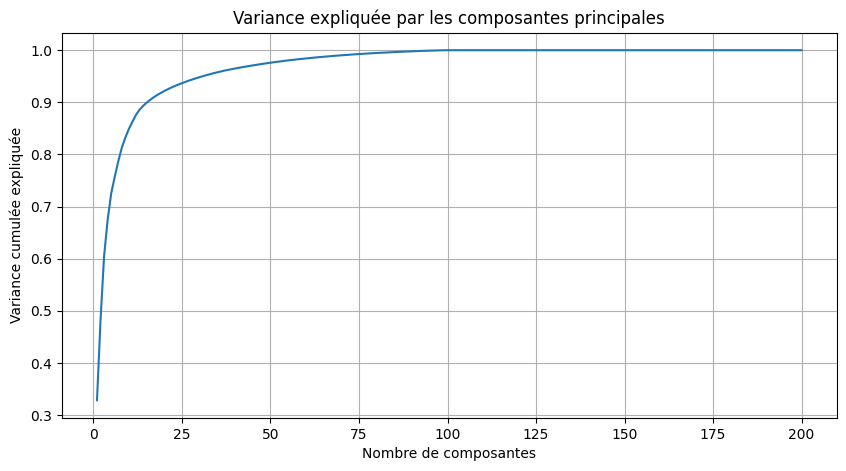

In [17]:
# Variance expliquée par chaque composante
explained_variance = pca_model.explainedVariance

print(f"📊 Variance expliquée:")
print(f"   Total: {sum(explained_variance):.4f}")
print(f"   Par composante (top 10):")
for i, var in enumerate(explained_variance[:10]):
    print(f"   PC{i+1}: {var:.6f}")

# Variance cumulée
import matplotlib.pyplot as plt
cumsum_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumsum_variance) + 1), cumsum_variance)
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance cumulée expliquée')
plt.title('Variance expliquée par les composantes principales')
plt.grid(True)
plt.show()

Seul 50 composantes principales expliquent déjà une grande partie de la variance. Je pourrais éventuellement réduire à k=50 pour un gain de performance supplémentaire, sans trop perdre en information.

### 6.4 Sauvegarde des features PCA (optionnel)

In [18]:
# ============================================================
# SAUVEGARDE DES RÉSULTATS PCA
# ============================================================

from pyspark.sql.functions import udf, concat_ws
from pyspark.sql.types import ArrayType, DoubleType, StringType
from pyspark.ml.linalg import VectorUDT, DenseVector

# Sélectionner les colonnes pertinentes
df_final = df_pca.select("path", "label", "pca_features")

# ============================================================
# OPTION 1: Sauvegarder en PARQUET (RECOMMANDÉ)
# ============================================================
# Parquet supporte nativement les vecteurs et est plus efficace
pca_output_path = str(PCA_DIR / "pca_results")
df_final.write.mode("overwrite").parquet(pca_output_path)
print(f"✅ Résultats PCA sauvegardés en Parquet: {pca_output_path}")

# ============================================================
# OPTION 2: Sauvegarder en CSV (pour inspection manuelle)
# ============================================================
# CSV ne supporte ni vecteurs ni arrays → Convertir en string

# UDF pour convertir Vector → String (format: "v1,v2,v3,...")
def vector_to_string(v):
    if v is None:
        return None
    return ",".join([str(float(x)) for x in v.toArray()])

vector_to_string_udf = udf(vector_to_string, StringType())

# Convertir le vecteur en string pour compatibilité CSV
df_final_csv = df_final.withColumn(
    "pca_features_string", 
    vector_to_string_udf(col("pca_features"))
).select("path", "label", "pca_features_string")

csv_output_path = str(PCA_DIR / "pca_results_csv")
df_final_csv.write.mode("overwrite").option("header", "true").csv(csv_output_path)
print(f"✅ Résultats PCA sauvegardés en CSV: {csv_output_path}")
print(f"   Note: Features PCA au format string (séparées par virgules)")

# ============================================================
# STATISTIQUES
# ============================================================
import os

parquet_files = list((PCA_DIR / "pca_results").glob("*.parquet"))
csv_files = list((PCA_DIR / "pca_results_csv").glob("*.csv"))

print(f"\n📊 Fichiers générés:")
print(f"   Parquet: {len(parquet_files)} fichier(s)")
print(f"   CSV: {len(csv_files)} fichier(s)")

# Taille des fichiers
if parquet_files:
    parquet_size = sum(f.stat().st_size for f in parquet_files) / 1024
    print(f"   Taille Parquet: {parquet_size:.1f} KB")
if csv_files:
    csv_size = sum(f.stat().st_size for f in csv_files) / 1024
    print(f"   Taille CSV: {csv_size:.1f} KB")

print(f"\n💡 Pour recharger les résultats:")
print(f"   # Parquet (recommandé):")
print(f"   df_pca_reload = spark.read.parquet('{pca_output_path}')")
print(f"   ")
print(f"   # CSV (pour inspection):")
print(f"   df_csv = spark.read.csv('{csv_output_path}', header=True)")

25/11/07 12:21:31 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


✅ Résultats PCA sauvegardés en Parquet: /home/david/projects/openclassrooms/projets/oc-ai-engineer-p11-realisez-traitement-environnement-big-data-cloud/data/pca/pca_results


25/11/07 12:21:32 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


✅ Résultats PCA sauvegardés en CSV: /home/david/projects/openclassrooms/projets/oc-ai-engineer-p11-realisez-traitement-environnement-big-data-cloud/data/pca/pca_results_csv
   Note: Features PCA au format string (séparées par virgules)

📊 Fichiers générés:
   Parquet: 1 fichier(s)
   CSV: 1 fichier(s)
   Taille Parquet: 138.5 KB
   Taille CSV: 406.2 KB

💡 Pour recharger les résultats:
   # Parquet (recommandé):
   df_pca_reload = spark.read.parquet('/home/david/projects/openclassrooms/projets/oc-ai-engineer-p11-realisez-traitement-environnement-big-data-cloud/data/pca/pca_results')
   
   # CSV (pour inspection):
   df_csv = spark.read.csv('/home/david/projects/openclassrooms/projets/oc-ai-engineer-p11-realisez-traitement-environnement-big-data-cloud/data/pca/pca_results_csv', header=True)


---
## 7. Tests et Validation

### 7.1 Vérification des dimensions

In [19]:
# Vérifier les dimensions à chaque étape
print("📊 Dimensions:")
print(f"   Images originales: {df_images.count()} images")
print(f"   Features extraites: {df_features.count()} images x 1280 features")
print(f"   Après PCA: {df_pca.count()} images x {K_COMPONENTS} features")

📊 Dimensions:
   Images originales: 100 images
   Features extraites: 100 images x 1280 features
   Après PCA: 100 images x 200 features


25/11/07 12:21:34 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


### 7.2 Test sur un échantillon

Tester le pipeline complet sur un petit échantillon pour valider.

In [20]:
# Prendre un échantillon de 100 images
sample_images = df_images.limit(100)

# Appliquer tout le pipeline
sample_with_labels = sample_images.withColumn(
    "label",
    element_at(split(col("path"), "/"), -2)
)

sample_features = sample_with_labels.withColumn(
    "features",
    extract_features_udf(col("content"))
).filter(col("features").isNotNull())

sample_vectors = sample_features.withColumn(
    "features_vector",
    array_to_vector(col("features"))
)

sample_pca = pca_model.transform(sample_vectors)

print(f"✅ Test sur échantillon: {sample_pca.count()} images traitées")
sample_pca.select("label", "pca_features").show(10, truncate=60)

✅ Test sur échantillon: 100 images traitées


25/11/07 12:21:47 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


+------------------+------------------------------------------------------------+
|             label|                                                pca_features|
+------------------+------------------------------------------------------------+
|    Apple Golden 1|[7.352743806843813,-4.115724129030099,-5.4234745353865605...|
|    Apple Golden 1|[-5.163980087502382,-0.1363167103077888,-9.11047233352926...|
|    Apple Golden 1|[-2.5380924346543723,-0.5054940784185926,0.22436678046764...|
|    Apple Golden 1|[-0.9090572190746973,-2.0859230077218074,-9.7499679050737...|
|    Apple Golden 1|[1.5604442793351574,-2.7408444057896295,-8.32755323813289...|
|Apple Red Yellow 1|[-10.500788488716342,-13.300569706917297,-2.2353543540111...|
|    Apple Golden 1|[-3.044486269601939,-0.36273624436328,-0.1045417174695123...|
|    Apple Golden 1|[-8.791419500026395,1.8874709946215,-5.5655876806914275,3...|
|    Apple Golden 1|[-9.476208394963969,1.0475423707524572,-4.913539041584769...|
|    Apple Golde

---
## 8. Nettoyage et Arrêt

### 8.1 Libérer les ressources

In [21]:
# Unpersist les DataFrames mis en cache (si utilisé .cache())
df_features.unpersist()
df_pca.unpersist()

# Détruire la variable broadcast
broadcast_weights.unpersist()

print("✅ Ressources libérées")

✅ Ressources libérées


### 8.2 Arrêt de la SparkSession

In [22]:
# Arrêter la SparkSession
spark.stop()
print("✅ SparkSession arrêtée")

✅ SparkSession arrêtée


---
## 📝 Notes pour la migration vers AWS EMR

### Changements à apporter:

1. **Chemins S3**
   ```python
   # Local
   image_path = "file:///path/to/images/*/*.jpg"
   
   # AWS EMR
   image_path = "s3://mon-bucket-fruits/data/raw/Training/*/*.jpg"
   ```

2. **Configuration Spark**
   - Sur EMR JupyterHub, la SparkSession est déjà créée
   - Pas besoin de `.master("local[*]")`
   - Le SparkContext est accessible via `spark.sparkContext`

3. **Installation de packages**
   - TensorFlow doit être installé via bootstrap actions ou dans le notebook
   - Sur EMR 7.10.0: TensorFlow 2.16.1 peut être pré-installé

4. **Sauvegarde des résultats**
   ```python
   # Sauvegarder directement sur S3
   df_pca.write.mode("overwrite").csv("s3://mon-bucket-fruits/data/pca/")
   ```

5. **Monitoring**
   - Utiliser Spark UI pour suivre l'exécution
   - Accessible via le tunnel SSH et FoxyProxy

### Checklist avant migration:

- ✅ Code validé en local sur un subset
- ✅ Broadcast des poids fonctionne correctement
- ✅ PCA appliquée et validée
- [ ] Chemins adaptés pour S3
- [ ] Dataset uploadé sur S3
- [ ] Cluster EMR créé et configuré
- [ ] Tunnel SSH et FoxyProxy configurés
- [ ] Accès JupyterHub vérifié